# Getting Started

Follow the general instructions from hw1_Q1

In [15]:
# magic for autoreloading of modules
%reload_ext autoreload
%autoreload 2

# get to the parent dir of mai_dul repo
import os
os.chdir('/teamspace/studios/this_studio/MAI_DUL_WS24')
# os.chdir('../../')
os.getcwd()

'/teamspace/studios/this_studio/MAI_DUL_WS24'

In [16]:
# run only once at the beginning of working on hw1
# !unzip -qq homeworks/hw1/data/hw1_data.zip -d homeworks/hw1/data/

# install latest version deepul package
!pip install -e .

Obtaining file:///teamspace/studios/this_studio/MAI_DUL_WS24
  Preparing metadata (setup.py) ... done
  Attempting uninstall: deepul
    Found existing installation: deepul 0.1.0
    Uninstalling deepul-0.1.0:
      Successfully uninstalled deepul-0.1.0
  DEPRECATION: Legacy editable install of deepul==0.1.0 from file:///teamspace/studios/this_studio/MAI_DUL_WS24 (setup.py develop) is deprecated. pip 25.0 will enforce this behaviour change. A possible replacement is to add a pyproject.toml or enable --use-pep517, and use setuptools >= 64. If the resulting installation is not behaving as expected, try using --config-settings editable_mode=compat. Please consult the setuptools documentation for more information. Discussion can be found at https://github.com/pypa/pip/issues/11457
  Running setup.py develop for deepul


In [17]:
import numpy as np
from deepul.hw1_helper import (
    # Q3
    q3ab_save_results,
    q3c_save_results,
)

# Question 3: Causal Transformer - iGPT

Now we will move onto the current most popular and widespread autoregressive model, the transformer.

## Part (a) Autoregressive Transformer on Shapes and MNIST
In this part, implement a simple Autoregressive Transformer to model binary MNIST and shapes images (same as Q2(a), but with a Transformer). 

Some additional notes about your transformer implementation:
 * iGPT uses learned positional encodings. We recommend to use those here as well. However, you may also use sinusoidal positional encodings if you wish (see the [Attention is All You Need](https://arxiv.org/abs/1706.03762) paper)
 * Autoregressive transformer always predicts the **next** token, give prior tokens. iGPT has a special **\<bos\>** or beginning of sequence token at the start of every sequence every image. Make sure to include this in your implementation as well. You can generate unconditional sample by conditioning with the **\<bos\>** token.
 * While dropout is a common feature in transformer models, you do not need to add it (but may if you wish!).
 * Prebuilt transformers exist in some frameworks (i.e. pytorch). Don't just use an off the shelf implementation as the point of the exercise is to better understand the transformer architecture. Building the transformer from the ground up (use primitives such as Linear/Dense layers, LayerNorm, GeLU, Embedding)
 * Learning rate warmup and cos learning rate decay are often used when training transformers to improve training stability and improve performance. See if this helps your model! Try 1000 steps of warmup with a cosine learning rate decay.

Paper references
* [Attention Is All You Need](https://arxiv.org/abs/1706.03762) 
* [Generative Pretraining from Pixels](https://cdn.openai.com/papers/Generative_Pretraining_from_Pixels_V2.pdf) 
* [Language Models are Unsupervised Multitask Learners](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf)

We recommend the following network design parameters:
* $d_{model}$: 128
* heads: 4
* layers: 2
* GeLU nonlinearities

And the following hyperparameters:
* Batch size: 64 or 32 or 16 (whichever fits in your GPU)
* Learning rate: $10^{-3}$
* 15 epochs or more
* Adam Optimizer (this applies to all Transformers models trained in future parts)

**You will provide these deliverables**

1. Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2. Report the final test set performance of your final model
3. 100 samples from the final trained model



In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np
from tqdm.notebook import tqdm

from torch.optim.lr_scheduler import LambdaLR
from homeworks.hw1.transformer import ImageGPT


In [19]:
def get_cosine_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps):
    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * progress)))
    
    return LambdaLR(optimizer, lr_lambda)

In [20]:
def prepare_data(data, device):
    B = data.size(0)
    data = data.view(B, -1)
    bos = torch.full((B, 1), 2, device=device, dtype=torch.long)  # 2 represents <bos>
    return torch.cat([bos, data], dim=1)

In [21]:
def train_one_epoch(model, train_loader, optimizer, scheduler, causal_mask, device):
    model.train()
    batch_losses = []
    pbar = tqdm(train_loader, unit='batch')

    for batch_idx, (batch,) in enumerate(pbar):
        if batch_idx % 10 == 0:
            torch.cuda.empty_cache()
        batch = batch.to(device)
        x = prepare_data(batch, device)
        
        # Create input and target sequences
        input_seq = x[:, :-1]  # All tokens except last
        target_seq = x[:, 1:]  # All tokens except first (<bos>)

        # Make sure we use the correct size of causal mask
        seq_len = input_seq.size(1)
        current_mask = causal_mask[:seq_len, :seq_len]
        
        # Forward pass
        optimizer.zero_grad()
        logits = model(input_seq, current_mask)
        
        # Calculate loss
        loss = F.cross_entropy(
            logits.reshape(-1, 2),  # Reshape to (batch_size * seq_len, num_classes)
            target_seq.reshape(-1)   # Reshape to (batch_size * seq_len)
        )
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()
        
        # Record losses
        batch_loss = loss.item()
        batch_losses.append(batch_loss)
        pbar.set_description(desc=f"batch_loss={batch_loss:.4f}")

    return batch_losses

In [22]:
def evaluate_model(model, test_loader, image_shape, device, causal_mask):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch, in test_loader:
            batch = batch.to(device)
            x = prepare_data(batch, device)
            input_seq = x[:, :-1]
            target_seq = x[:, 1:]

            # Make sure we use the correct size of causal mask
            seq_len = input_seq.size(1)
            current_mask = causal_mask[:seq_len, :seq_len]

            logits = model(input_seq, current_mask)
            loss = F.cross_entropy(logits.reshape(-1, 2), target_seq.reshape(-1))
            total_loss += loss.item()
    
    return total_loss / len(test_loader)

In [23]:
def train_model(model, train_loader, test_loader, optimizer, scheduler, num_epochs, image_shape, device):

    # Create causal mask once
    seq_len = image_shape[0] * image_shape[1] + 1
    causal_mask = torch.tril(torch.ones(seq_len, seq_len, device=device))
    
    train_losses = []
    test_losses = []
    test_losses = [evaluate_model(model, test_loader, image_shape, device, causal_mask)]
    
    for epoch in range(num_epochs):
        # Train one epoch
        batch_losses = train_one_epoch(
            model=model,
            train_loader=train_loader,
            optimizer=optimizer,
            scheduler=scheduler,
            causal_mask=causal_mask,
            device=device
        )
        
        # Record losses
        train_losses.extend(batch_losses)
        
        # Evaluate on test set
        test_loss = evaluate_model(model, test_loader, image_shape, device, causal_mask)
        test_losses.append(test_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Test Loss: {test_loss:.4f}')
    
    torch.cuda.empty_cache()
    return train_losses, test_losses

In [24]:
def generate_samples(model, image_shape, device, num_samples=100):
    model.eval()
    H, W, C = image_shape
    seq_len = H * W
    
    with torch.no_grad():
        # Start with batch of <bos> tokens
        x = torch.full((num_samples, 1), 2, device=device)  # 2 represents <bos>
        
        # Generate one pixel at a time
        for _ in range(seq_len):
            logits = model(x)
            probs = F.softmax(logits[:, -1, :], dim=-1)
            next_token = torch.multinomial(probs, 1)
            x = torch.cat([x, next_token], dim=1)
        
        # Remove <bos> token and reshape
        samples = x[:, 1:].cpu().numpy()
        samples = samples.reshape(num_samples, H, W, C)
    
    return samples

In [28]:
def q3_a(train_data, test_data, image_shape, dset_id):
    """
    train_data: A (n_train, H, W, 1) uint8 numpy array of color images with values in {0, 1}
    test_data: A (n_test, H, W, 1) uint8 numpy array of color images with values in {0, 1}
    image_shape: (H, W, 1), height, width, and # of channels of the image
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
            used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, W, 1) of samples with values in {0, 1}
    """

    torch.manual_seed(1)

    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() 
                         else "mps" if torch.backends.mps.is_available() 
                         else "cpu")
    print(f"Using device: {device}")
    
    # DataLoader settings based on device
    kwargs = {'num_workers': 0, 'pin_memory': False} if torch.cuda.is_available() else \
            {'num_workers': 0} if torch.backends.mps.is_available() else \
            {}
    


    # Hyperparameters
    d_model = 128
    num_heads = 4
    num_layers = 2
    batch_size = 128
    learning_rate = 1e-3
    num_epochs = 15

    
    # Data preprocessing
    train_data = torch.from_numpy(train_data).to(device)
    test_data = torch.from_numpy(test_data).to(device)
    
    # Create data loaders
    train_dataset = torch.utils.data.TensorDataset(train_data)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
    
    test_dataset = torch.utils.data.TensorDataset(test_data)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Initialize model
    model = ImageGPT(image_shape).to(device)
    # # Initialize the parameters
    # for p in model.parameters():
    #     if p.dim() > 1:
    #         nn.init.xavier_uniform_(p)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Learning rate schedule
    num_training_steps = len(train_loader) * num_epochs
    num_warmup_steps = 1000
    scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps)

    train_losses, test_losses = train_model(
                        model=model,
                        train_loader=train_loader,
                        test_loader=test_loader,
                        optimizer=optimizer,
                        scheduler=scheduler,
                        num_epochs=num_epochs,
                        image_shape=image_shape,
                        device=device
                    )

    # Generate samples
    samples = generate_samples(model, image_shape, device, num_samples=100)
    
    return np.array(train_losses), np.array(test_losses), samples


### Results

Once you've implemented `q3_a`, execute the cells below to visualize and save your results

Using device: cuda


  0%|          | 0/328 [00:00<?, ?batch/s]

Epoch 1/15, Test Loss: 0.0863


  0%|          | 0/328 [00:00<?, ?batch/s]

Epoch 2/15, Test Loss: 0.0600


  0%|          | 0/328 [00:00<?, ?batch/s]

Epoch 3/15, Test Loss: 0.0555


  0%|          | 0/328 [00:00<?, ?batch/s]

Epoch 4/15, Test Loss: 0.0472


  0%|          | 0/328 [00:00<?, ?batch/s]

Epoch 5/15, Test Loss: 0.0427


  0%|          | 0/328 [00:00<?, ?batch/s]

Epoch 6/15, Test Loss: 0.0419


  0%|          | 0/328 [00:00<?, ?batch/s]

Epoch 7/15, Test Loss: 0.0399


  0%|          | 0/328 [00:00<?, ?batch/s]

Epoch 8/15, Test Loss: 0.0388


  0%|          | 0/328 [00:00<?, ?batch/s]

Epoch 9/15, Test Loss: 0.0380


  0%|          | 0/328 [00:00<?, ?batch/s]

Epoch 10/15, Test Loss: 0.0365


  0%|          | 0/328 [00:00<?, ?batch/s]

Epoch 11/15, Test Loss: 0.0355


  0%|          | 0/328 [00:00<?, ?batch/s]

Epoch 12/15, Test Loss: 0.0347


  0%|          | 0/328 [00:00<?, ?batch/s]

Epoch 13/15, Test Loss: 0.0341


  0%|          | 0/328 [00:00<?, ?batch/s]

Epoch 14/15, Test Loss: 0.0338


  0%|          | 0/328 [00:00<?, ?batch/s]

Epoch 15/15, Test Loss: 0.0337
Final Test Loss: 0.0337


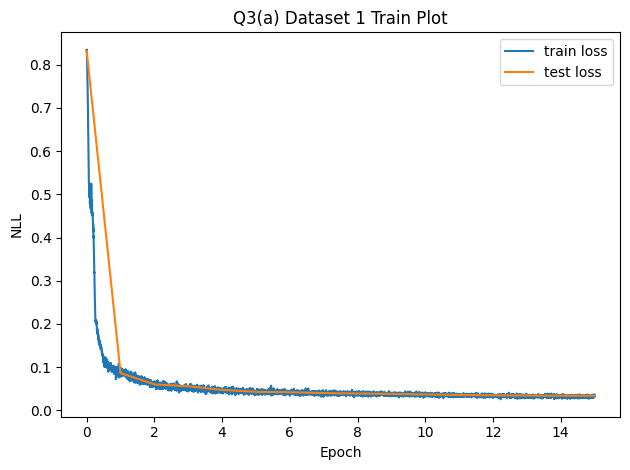

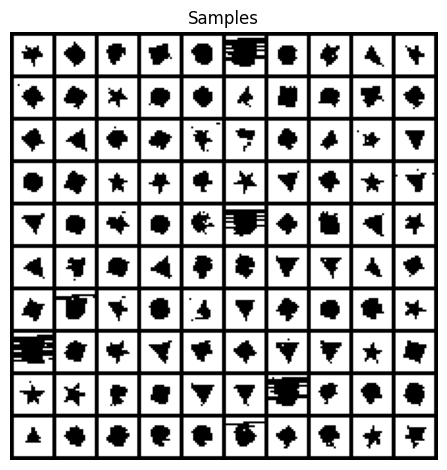

In [26]:
q3ab_save_results(1, 'a', q3_a)

Using device: cuda


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 1/15, Test Loss: 0.1391


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 2/15, Test Loss: 0.0904


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 3/15, Test Loss: 0.0837


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 4/15, Test Loss: 0.0805


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 5/15, Test Loss: 0.0796


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 6/15, Test Loss: 0.0779


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 7/15, Test Loss: 0.0775


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 8/15, Test Loss: 0.0764


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 9/15, Test Loss: 0.0755


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 10/15, Test Loss: 0.0749


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 11/15, Test Loss: 0.0744


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 12/15, Test Loss: 0.0740


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 13/15, Test Loss: 0.0736


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 14/15, Test Loss: 0.0734


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 15/15, Test Loss: 0.0733
Final Test Loss: 0.0733


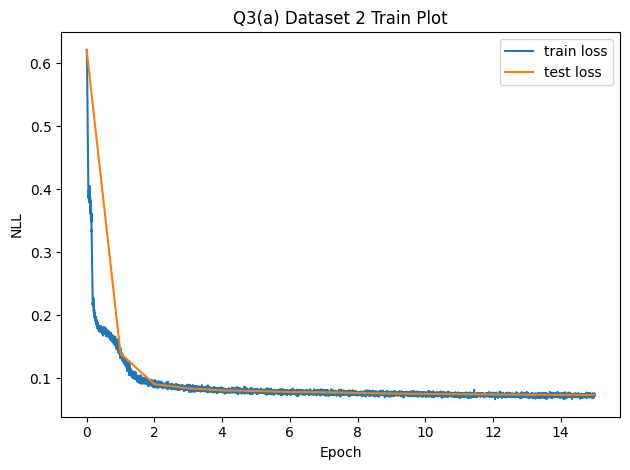

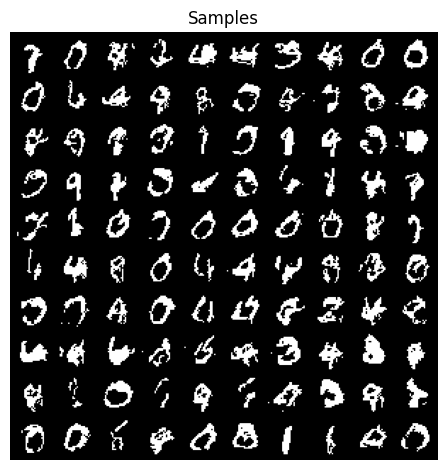

In [29]:
q3ab_save_results(2, 'a', q3_a)

## Part (b) iGPT on Colored Shapes and MNIST

Now, implement an iGPT that models color. In order to reduce the length of token sequences, iGPT models each RGB pixel as a **single** token. This effectively reduces the context length from H*W*C to just H*W. iGPT does this through a k-means clustering approach. Because our images only each can only take on 4 values (2 bits) per channel, we can represent each pixel with 64 values (6 bits). Convert the dataset into an image of tokens and train iGPT on the colored shapes and MNIST dataset.

Checkout the iGPT paper for more details: [Generative Pretraining from Pixels](https://cdn.openai.com/papers/Generative_Pretraining_from_Pixels_V2.pdf) 

Training times and hyperparameter settings should be the same as part (a), except train for longer (15 epochs)

**You will provide these deliverables**

1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model


In [ ]:
def q3_b(train_data, test_data, image_shape, dset_id):
  """
  train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  image_shape: (H, W, C), height, width, and # of channels of the image
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, C) of samples with values in {0, 1, 2, 3}
  """

  return train_losses, test_losses, samples

### Results

Once you've implemented `q3_b`, execute the cells below to visualize and save your results

In [ ]:
q3ab_save_results(1, 'b', q3_b)

In [ ]:
q3ab_save_results(2, 'b', q3_b)